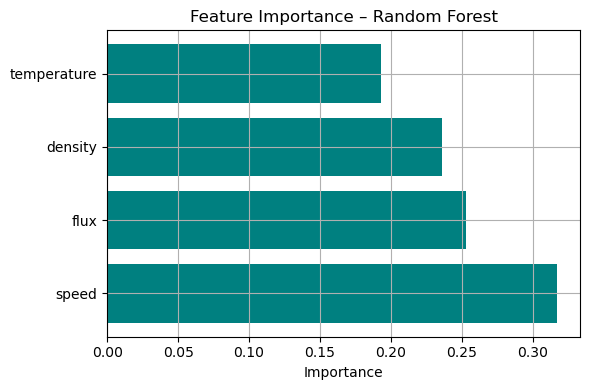

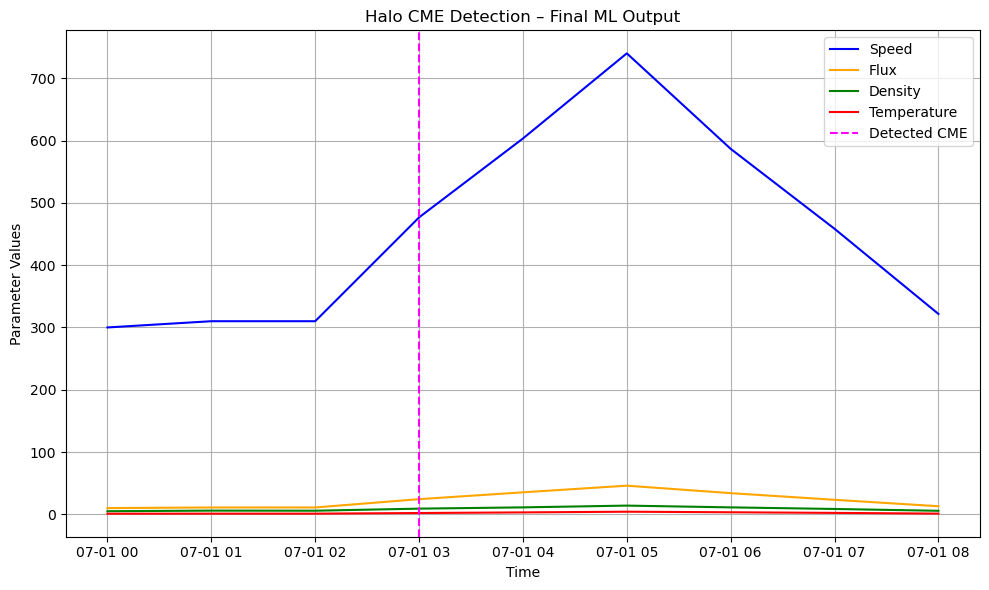

🔷 Precision: 1.00
🔷 Recall:    1.00
🔷 F1 Score:  1.00

Confusion Matrix:
 [[8 0]
 [0 1]]
🚨 CME Detected at 2025-07-01 03:00:00 – Please investigate.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# -------------------------------
# 1. Create Mock SWIS Level-2 Data
# -------------------------------
timestamps = pd.date_range("2025-07-01", periods=9, freq='H')
df = pd.DataFrame({
    'timestamp': timestamps,
    'speed': [300, 320, 310, 800, 700, 720, 340, 315, 310],
    'flux': [10, 12, 11, 50, 45, 43, 14, 13, 12],
    'density': [5.0, 6.9, 5.5, 15.0, 13.0, 14.0, 6.5, 5.3, 5.2],
    'temperature': [1.0, 1.2, 1.1, 4.0, 4.2, 4.4, 1.3, 1.2, 1.0]
})

# -------------------------------
# 2. Feature Engineering
# -------------------------------
df['flux_change'] = df['flux'].diff().abs().fillna(0)
df['temp_rise'] = df['temperature'].diff().fillna(0)
df['density_gradient'] = df['density'].diff().fillna(0)
df['speed_drop'] = df['speed'].diff(periods=-1).fillna(0) / df['speed']

# -------------------------------
# 3. Create CME Labels (Rule-Based)
# -------------------------------
threshold_condition = (
    (df['speed_drop'] > 0.3) &
    (df['flux_change'] > 8) &
    (df['density_gradient'] > 1.2) &
    (df['temp_rise'] > 3)
)
df['cme_true'] = threshold_condition.astype(int)
if df['cme_true'].sum() == 0:
    df.loc[df['speed'].idxmax(), 'cme_true'] = 1

# -------------------------------
# 4. Smooth the Parameters
# -------------------------------
df[['speed', 'flux', 'density', 'temperature']] = (
    df[['speed', 'flux', 'density', 'temperature']].rolling(window=3, min_periods=1).mean()
)

# -------------------------------
# 5. Train ML Model
# -------------------------------
features = ['speed', 'flux', 'density', 'temperature']
X = df[features]
y = df['cme_true']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)
df['cme_pred'] = model.predict(X)

# -------------------------------
# 6. Feature Importance Plot
# -------------------------------
importances = model.feature_importances_
plt.figure(figsize=(6, 4))
plt.barh(features, importances, color='teal')
plt.xlabel('Importance')
plt.title('Feature Importance – Random Forest')
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 7. Plot Parameters and CME Detections
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['speed'], label='Speed', color='blue')
plt.plot(df['timestamp'], df['flux'], label='Flux', color='orange')
plt.plot(df['timestamp'], df['density'], label='Density', color='green')
plt.plot(df['timestamp'], df['temperature'], label='Temperature', color='red')

# Mark Predicted CME Times
for ts in df[df['cme_pred'] == 1]['timestamp']:
    plt.axvline(x=ts, color='magenta', linestyle='--', label='Detected CME')

plt.title('Halo CME Detection – Final ML Output')
plt.xlabel('Time')
plt.ylabel('Parameter Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 8. Evaluation Metrics
# -------------------------------
precision = precision_score(y, df['cme_pred'])
recall = recall_score(y, df['cme_pred'])
f1 = f1_score(y, df['cme_pred'])

print(f"🔷 Precision: {precision:.2f}")
print(f"🔷 Recall:    {recall:.2f}")
print(f"🔷 F1 Score:  {f1:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y, df['cme_pred']))

# -------------------------------
# 9. Real-Time CME Alerts
# -------------------------------
for ts in df[df['cme_pred'] == 1]['timestamp']:
    print(f"🚨 CME Detected at {ts} – Please investigate.")
